In [3]:
# 1. Mount Google Drive and Set Dataset Path

from google.colab import drive
drive.mount('/content/drive')

# Base dataset path (adjust if necessary)
base_dir = '/content/drive/MyDrive/cats_vs_dogs/cats_vs_dogs_small/cats_vs_dogs_small'

# Import Required Libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

print("Base directory contents:", os.listdir(base_dir))


Mounted at /content/drive
Base directory contents: ['train', 'validation', 'test']


In [4]:
# 2. Load and Prepare Dataset

train_dir = pathlib.Path(base_dir + '/train')
val_dir = pathlib.Path(base_dir + '/validation')
test_dir = pathlib.Path(base_dir + '/test')

train_dataset = image_dataset_from_directory(train_dir, image_size=(180,180), batch_size=32)
val_dataset = image_dataset_from_directory(val_dir, image_size=(180,180), batch_size=32)
test_dataset = image_dataset_from_directory(test_dir, image_size=(180,180), batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1015 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Class names: ['cats', 'dogs']


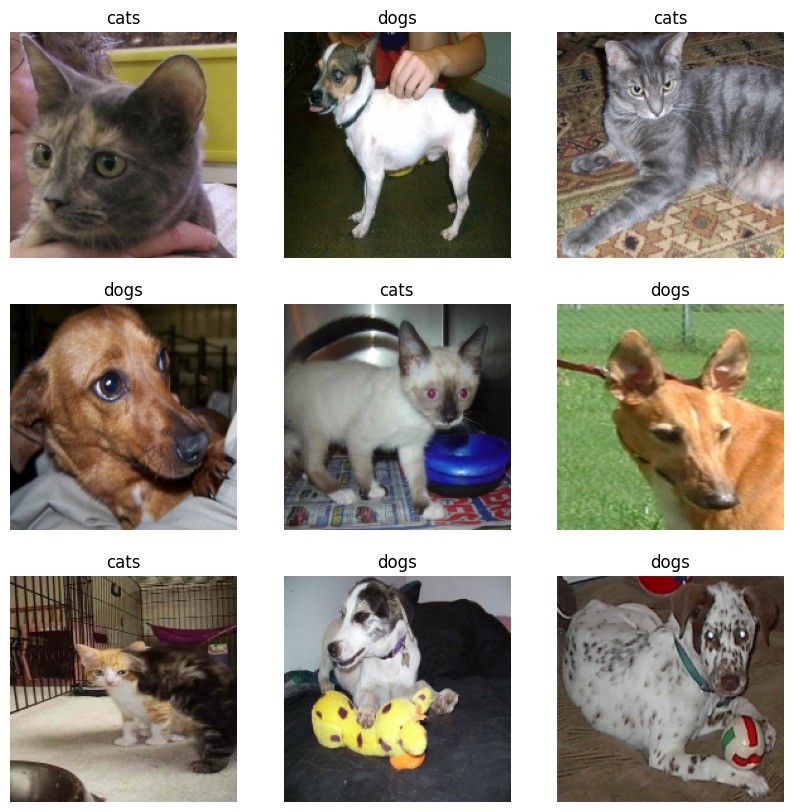

In [5]:

#2.5 Visualize Sample Images from the Dataset

import matplotlib.pyplot as plt
class_names = train_dataset.class_names
print("Class names:", class_names)

# Display 9 sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()



In [7]:
# 3.Create Training Subsets
# Create Subsets for Different Training Sample Sizes

# Create subsets representing different sample sizes
small_train_dataset = train_dataset.take(32)   # ~1000 images
medium_train_dataset = train_dataset.take(96)  # ~3000 images
large_train_dataset = train_dataset            # full dataset


In [8]:
# 4. Data Augmentation and Prefetch Optimization

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

AUTOTUNE = tf.data.AUTOTUNE

# Cache and prefetch for performance
small_train_dataset = small_train_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
medium_train_dataset = medium_train_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
large_train_dataset = large_train_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


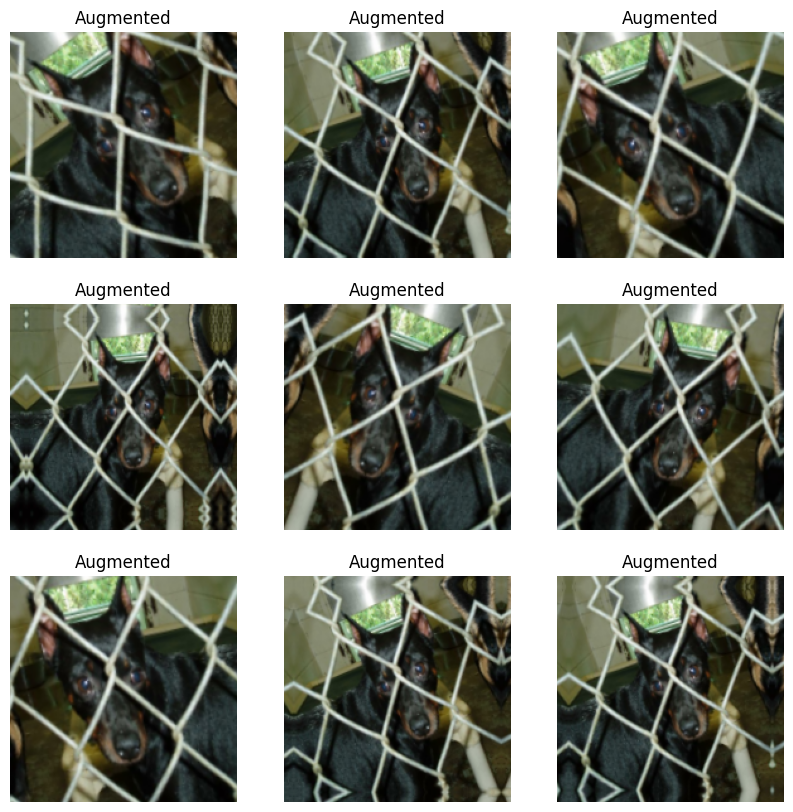

In [11]:
# 4.5 Visualize Data Augmentation Effects

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")
plt.show()


In [9]:
# 5. Define CNN Architecture (From Scratch)

def create_scratch_model():
    inputs = keras.Input(shape=(180,180,3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [6]:
# 6 – Train CNN from Scratch (Small, Medium, Full Datasets)

#  Train CNN from Scratch on Different Sample Sizes


print("Training CNN (Scratch) - Small dataset (~1000 images)")
model_small = create_scratch_model()
history_small = model_small.fit(small_train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])

print("\nTraining CNN (Scratch) - Medium dataset (~3000 images)")
model_medium = create_scratch_model()
history_medium = model_medium.fit(medium_train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])

print("\nTraining CNN (Scratch) - Full dataset")
model_large = create_scratch_model()
history_large = model_large.fit(large_train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])


Training CNN (Scratch) - Small dataset (~1000 images)
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 603s 12s/step - accuracy: 0.4702 - loss: 0.7233 - val_accuracy: 0.5074 - val_loss: 0.6956
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5132 - loss: 0.6949 - val_accuracy: 0.5379 - val_loss: 0.6837
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6149 - loss: 0.6687 - val_accuracy: 0.6552 - val_loss: 0.6763
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5979 - loss: 0.6712 - val_accuracy: 0.5547 - val_loss: 0.7011
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6141 - loss: 0.6726 - val_accuracy: 0.6335 - val_loss: 0.6524
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6791 - loss: 0.6262 - val_accuracy: 0.6788 - val_loss: 0.6151
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6739 - loss: 0.5957 - val_accuracy: 0.6670 - val_loss: 0.6131
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc

In [7]:
#7 – Build Pretrained ResNet50 Model

# Pretrained Model (Transfer Learning with ResNet50)


conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(180,180,3))
conv_base.trainable = False  # Freeze base for initial training

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_pretrained = keras.Model(inputs, outputs)
model_pretrained.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                          loss='binary_crossentropy', metrics=['accuracy'])

print("\nTraining Pretrained ResNet50 (Frozen Base)...")
history_pretrained = model_pretrained.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[callback])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Training Pretrained ResNet50 (Frozen Base)...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7168 - loss: 0.5557 - val_accuracy: 0.9714 - val_loss: 0.1013
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.9296 - loss: 0.1765 - val_accuracy: 0.9764 - val_loss: 0.0669
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.9432 - loss: 0.1343 - val_accuracy: 0.9803 - val_loss: 0.0546
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.9558 - loss: 0.1075 - val_accuracy: 0.9833 - val_loss: 0.0470
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9644 - loss: 0.0859 - val_accuracy: 0.9813 - val_loss: 0.0467
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.9667 - loss: 0.0922 - val_accuracy: 0.9823 - val_loss: 0.0460
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9707 - loss: 0.0828 - val_accuracy: 0.9833 - val_loss: 0.0423

In [8]:
#8 – Fine-Tune Pretrained Model

# Fine-tune the Top Layers of ResNet50

conv_base.trainable = True
for layer in conv_base.layers[:-50]:  # Unfreeze top 50 layers
    layer.trainable = False

model_pretrained.compile(optimizer=keras.optimizers.Adam(1e-5),
                          loss='binary_crossentropy', metrics=['accuracy'])

print("\nFine-tuning Pretrained ResNet50 (Top 50 layers)...")
history_finetune = model_pretrained.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[callback])



Fine-tuning Pretrained ResNet50 (Top 50 layers)...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 263ms/step - accuracy: 0.9426 - loss: 0.1467 - val_accuracy: 0.9823 - val_loss: 0.0379
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.9654 - loss: 0.0889 - val_accuracy: 0.9823 - val_loss: 0.0373
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9760 - loss: 0.0722 - val_accuracy: 0.9813 - val_loss: 0.0407
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9753 - loss: 0.0673 - val_accuracy: 0.9833 - val_loss: 0.0394
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9813 - loss: 0.0525 - val_accuracy: 0.9842 - val_loss: 0.0387



Evaluating Models...
32/32 ━━━━━━━━━━━━━━━━━━━━ 360s 11s/step - accuracy: 0.6948 - loss: 0.6020
Test Accuracy (Scratch - Small): 0.674
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7348 - loss: 0.5625
Test Accuracy (Scratch - Medium): 0.736
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7159 - loss: 0.5536
Test Accuracy (Scratch - Full): 0.712
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9878 - loss: 0.0387
Test Accuracy (Pretrained - Fine-tuned): 0.981


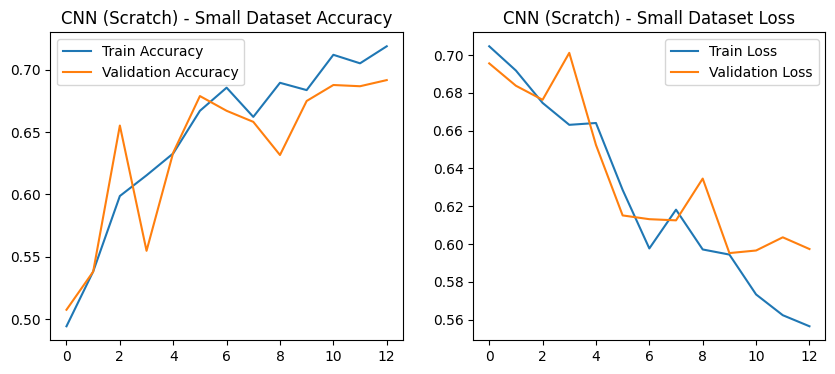

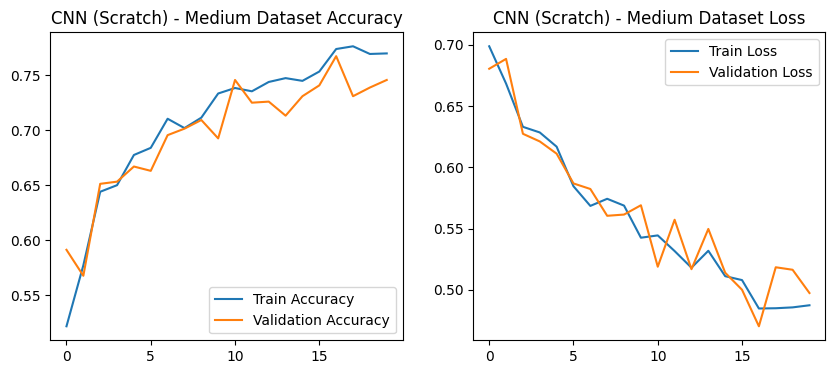

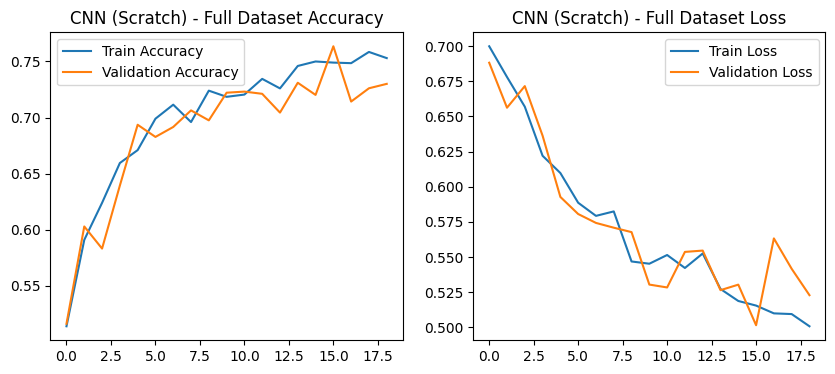

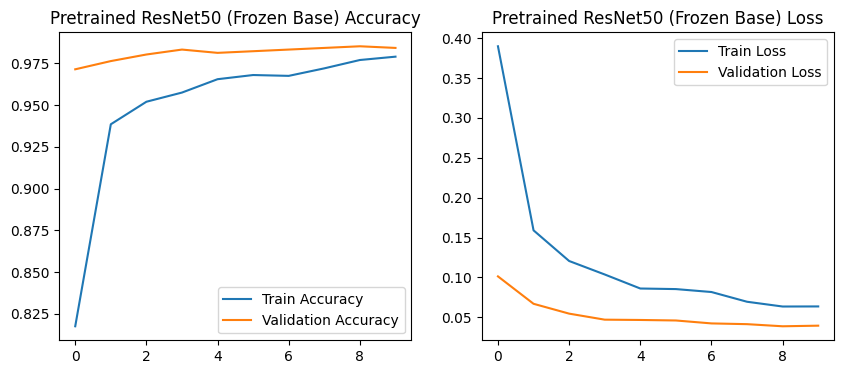

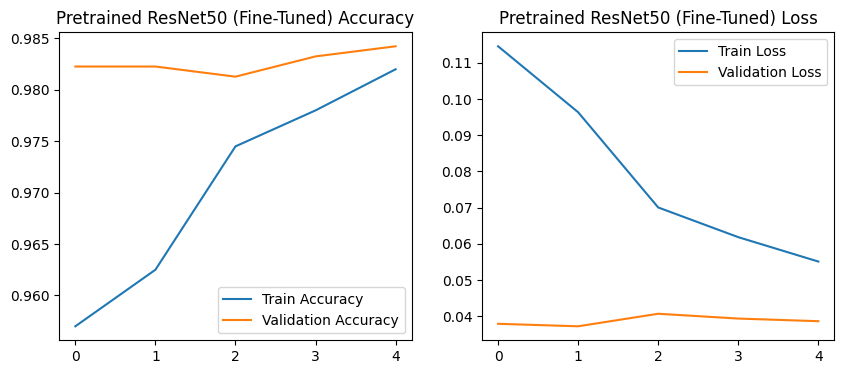

In [9]:
# 9 – Evaluate Models and Plot Results

# Evaluate All Models and Plot Accuracy/Loss

print("\nEvaluating Models...")
small_loss, small_acc = model_small.evaluate(test_dataset)
print(f"Test Accuracy (Scratch - Small): {small_acc:.3f}")

med_loss, med_acc = model_medium.evaluate(test_dataset)
print(f"Test Accuracy (Scratch - Medium): {med_acc:.3f}")

large_loss, large_acc = model_large.evaluate(test_dataset)
print(f"Test Accuracy (Scratch - Full): {large_acc:.3f}")

pt_loss, pt_acc = model_pretrained.evaluate(test_dataset)
print(f"Test Accuracy (Pretrained - Fine-tuned): {pt_acc:.3f}")

# --- Plot Training Histories ---
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_small, "CNN (Scratch) - Small Dataset")
plot_history(history_medium, "CNN (Scratch) - Medium Dataset")
plot_history(history_large, "CNN (Scratch) - Full Dataset")
plot_history(history_pretrained, "Pretrained ResNet50 (Frozen Base)")
plot_history(history_finetune, "Pretrained ResNet50 (Fine-Tuned)")


In [16]:
# 10 – Best Accuracy Summary & Markdown Report

# Summary: Extract Best Validation Accuracies & Markdown Report

def best_val_acc(history):
    return max(history.history['val_accuracy'])

print("\n--- Best Validation Accuracies ---")
print(f"Scratch (Small):  {best_val_acc(history_small):.3f}")
print(f"Scratch (Medium): {best_val_acc(history_medium):.3f}")
print(f"Scratch (Full):   {best_val_acc(history_large):.3f}")
print(f"Pretrained (Fine-Tuned): {best_val_acc(history_finetune):.3f}")

print("""
**Conclusions:**
- Smaller datasets overfit more easily when training from scratch.
- Increasing training samples improves stability and accuracy.
- Pretrained models perform better with limited data.
- Data augmentation, dropout, and early stopping reduce overfitting effectively.
""")


--- Best Validation Accuracies ---
Scratch (Small):  0.692
Scratch (Medium): 0.767
Scratch (Full):   0.764
Pretrained (Fine-Tuned): 0.984

**Conclusions:**
- Smaller datasets overfit more easily when training from scratch.
- Increasing training samples improves stability and accuracy.
- Pretrained models perform better with limited data.
- Data augmentation, dropout, and early stopping reduce overfitting effectively.

